<a href="https://colab.research.google.com/github/alby1976/Data607608Project/blob/master/notebook/DATA607_GroupProject_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Question 1
**Is there any pattern of solved or unsolved cases based on the type of victim, weapon, circumstance and geography region where crimes were occurred?**

To address this question, we implemented below three models to predict Solved or Unsolved cases with Case level records reported by Murder Accountability Project.
 
- Classification models with `scikit-lean`: 
  `Gausian Naive Bayes Classifer` and `Regression forest classifer`
- Deep learning Model with `Tensorflows` and `keras`:
  `Neural Network`

Murder Accountability Projects compiled various information such as geographic location, Victim profile, Offender profile, year/month, type of weapon, relationship between victim and offender, homicide type, circumstance etc for 804751 caeses from 1976 to 2019.

For our prediction model, we used "solved" column (yes, or no) as a response variable and feed others as explanatory variables.


## Setup

In [71]:
!pip install scikit-learn --upgrade
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install GraphViz --upgrade


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
Requirement already up-to-date: GraphViz in /usr/local/lib/python3.7/dist-packages (0.16)


In [72]:

#mount Google drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive' # default for the drive
print(ROOT)
drive.mount(ROOT) # we mount the drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

filedir = '/content/drive/MyDrive/Project 607!608'
if filedir.endswith('/') != True:
  filedir += '/'
  
def convert (df, colname, lookup):
  df.loc[df[colname] == lookup[0], colname] = lookup[1]
  return df

def convert_list (df, colname, lookups):
  for lookup in lookups:
    df = convert(df, colname, lookup)
  return df

# Conversion array
agegroup = zip([x for x in range (0, 19)], ['Total', 
  'Age 0 to 4 years', 
  'Age 5 to 9 years', 
  'Age 10 to 14 years',
  'Age 15 to 19 years', 
  'Age 20 to 24 years', 
  'Age 25 to 29 years', 
  'Age 30 to 34 years', 
  'Age 35 to 39 years', 
  'Age 40 to 44 years', 
  'Age 45 to 49 years', 
  'Age 50 to 54 years', 
  'Age 55 to 59 years', 
  'Age 60 to 64 years', 
  'Age 65 to 69 years', 
  'Age 70 to 74 years', 
  'Age 75 to 79 years', 
  'Age 80 to 84 years', 
  'Age 85 years or older'])

def calculate_agegroup(age):
  if age == 999:
    return 0
  elif age >= 85:
    return 18
  else:
    return (age // 5) + 1

# conversion array
solved = zip(['Yes', 'No'],[True, False])
month = zip(['January', 'February', 'March', 'April', 'May','June', 'July', 'August', 'September','October', 'November', 'December'], [x for x in range(1,13)])

#column data type

category = ['ID', 'CNTYFIPS', 'Ori', 'State', 'Agency', 'Agentype',
       'Source', 'Solved', 'ActionType',
       'Homicide', 'Situation', 'VicSex', 'VicRace', 'VicEthnic',
       'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicAgeGroup', 'OffAgeGroup']
murder = pd.read_csv(filedir + 'SHR76_19.csv')
murder.to_parquet('SHR76_19.parquet', index=False)
murder = pd.read_parquet('SHR76_19.parquet')
loc = murder[['State','CNTYFIPS']]
ages = murder.VicAge
murder['VicAgeGroup'] = [calculate_agegroup(age) for age in ages] 
ages = murder.OffAge
murder['OffAgeGroup'] = [calculate_agegroup(age) for age in ages]
murder.VicCount += 1
murder.OffCount += 1
#murder = convert_list(murder,'Solved', solved)
murder = convert_list(murder,'Month', month)
murder.Month = murder.Month.apply(pd.to_numeric)
#murder.FileDate = pd.to_datetime(murder.FileDate, format='%m%d%y')
murder.loc[:,category] = murder.loc[:,category].astype('category')


## Neural Network - Victim's demographics


# Appendix


In [ ]:
%%file my_classes.py

import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

Writing my_classes.py


In [ ]:
# import numpy as np

# from sklearn.compose import ColumnTransformer
# from sklearn.datasets import fetch_openml
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import LabelBinarizer
# from sklearn import metrics
# import matplotlib.pyplot as plt

# from keras.layers import Dense, Dropout
# from keras.models import Model, Sequential
# from keras.wrappers.scikit_learn import KerasClassifier

# # create a function that returns a model, taking as parameters things you
# # want to verify using cross-valdiation and model selection
# def create_model(optimizer='adagrad',
#                  kernel_initializer='glorot_uniform',
#                  dropout=0.5):
#     model = Sequential()
#     model.add(Dense(32,activation='relu',kernel_initializer=kernel_initializer))
#     model.add(Dropout(dropout))
#     model.add(Dense(32,activation='relu',kernel_initializer=kernel_initializer))
#     model.add(Dropout(dropout))
#     model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

#     model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

#     return model

# # wrap the model using the function you created
# clf = KerasClassifier(build_fn=create_model,epochs=10, batch_size=32, verbose=2)

# # create parameter grid, as usual, but note that you can
# # vary other model parameters such as 'epochs' (and others 
# # such as 'batch_size' too)

# #optimizers = ['rmspro', 'adam', 'sgd']
# #initializers = ['glorot_uniform', 'normal', 'uniform']
# epochs = [5, 10 ,25]
# dropout = [0.1, 0.2, 0.5]
# batches = [ 8, 16, 64]
# #param_grid = dict(
# #    optimizer = optimizers, 
#     #epochs = epochs, 
#     #batch_size=batches, 
# #    inititializer=initializers) 
# #param_grid = {
# #    'classifer__optimizer':['rmsprop','adam','adagrad'],
# #    'classifer__epochs': [4, 8, 10 ],
# #    'classifer__dropout': [0.1,0.2, 0.5],
# #    'classifer__kernel_initializer':['glorot_uniform','normal','uniform']}
# seed = 42
# cat = np.array(df.select_dtypes(include=['category']).columns)
# num = np.array(df.select_dtypes(exclude=['category']).columns)
# display(cat,num)

# numeric_features = num
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# categorical_features = cat
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)])

# # Append classifier to preprocessing pipeline.
# # Now we have a full prediction pipeline.
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', pipeline)])

# X_train, X_test, y_train, y_test = train_test_split(preprocessor X, y, test_size=0.2,
#                                                     random_state=seed)

# pipeline.fit(X_train, y_train)

# #%%
# # Evaluation
# y_pred = pipeline.predict(X_test)

# print()
# print(np.mean((y_test.values) == y_pred))

# print()
# print("NN using RBM features:\n%s\n" % (
# metrics.classification_report(
#   y_test,
#   pipeline.predict(X_test))))

# #%%
# # Plotting

# plt.figure(figsize=(4.2, 4))
# for i, comp in enumerate(rbm.components_):
#   plt.subplot(10, 10, i + 1)
#   plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
#     interpolation='nearest')
#   plt.xticks(())
#   plt.yticks(())
# plt.suptitle('64 components extracted by RBM', fontsize=16)
# plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
# plt.show()
# print('\n',pipeline.get_params().keys(),'\n')


## Neural Network - Offender's demographics


In [67]:
import numpy as np

from sklearn.compose import ColumnTransformer
#from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier

df_offender = murder[['CNTYFIPS', 'State', 'Solved','Year', 'Incident', 'Homicide', 'Situation', 'OffAge', 'OffSex', 'OffRace', 'OffEthnic',
       'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount']]
df_offender = df_offender.dropna()

solvedBinarizer = LabelBinarizer().fit(df_offender.Solved)
X = df_offender.drop(columns=['Solved'])
y = solvedBinarizer.transform(df_offender.Solved)
df_offender.drop(columns=['Solved'], inplace=True)

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform',
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(6,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

# wrap the model using the function you created
clf_offender = KerasClassifier(build_fn=create_model,epochs=10, batch_size=32, verbose=2)

# create parameter grid, as usual, but note that you can
# vary other model parameters such as 'epochs' (and others 
# such as 'batch_size' too)

#optimizers = ['rmspro', 'adam', 'sgd']
#initializers = ['glorot_uniform', 'normal', 'uniform']

seed = 42
cat_offender = np.array(df_offender.select_dtypes(include=['category']).columns)
num_offender= np.array(df_offender.select_dtypes(exclude=['category']).columns)
display(cat_offender,num_offender)

numeric_features = num_offender
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = cat_offender
categorical_transformer = OneHotEncoder(handle_unknown='ignore', )

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

pipeline_offender = Pipeline(steps=[('classifier', clf_offender)])

X_train, X_test, y_train, y_test = train_test_split(preprocessor.fit_transform(X), y, test_size=0.2,
                                                    random_state=seed)
pipeline_offender.fit(X_train, y_train, classifier__validation_data=(X_test, y_test))

#%%
# Evaluation
#y_pred = (pipeline.predict(X_test) > 0.5).astype("int32")
y_pred = pipeline_offender.predict(X_test)
print()
print(np.mean((y_test) == y_pred))




array(['CNTYFIPS', 'State', 'Homicide', 'Situation', 'OffSex', 'OffRace',
       'OffEthnic', 'Weapon', 'Relationship', 'Circumstance', 'Subcircum'],
      dtype=object)

array(['Year', 'Incident', 'OffAge', 'VicCount', 'OffCount'], dtype=object)

Epoch 1/10
788/788 - 2s - loss: 0.1352 - accuracy: 0.9775 - val_loss: 0.0094 - val_accuracy: 0.9989
Epoch 2/10
788/788 - 2s - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 3/10
788/788 - 2s - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0027 - val_accuracy: 0.9992
Epoch 4/10
788/788 - 2s - loss: 0.0112 - accuracy: 0.9953 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 5/10
788/788 - 2s - loss: 0.0099 - accuracy: 0.9959 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 6/10
788/788 - 2s - loss: 0.0093 - accuracy: 0.9962 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 7/10
788/788 - 2s - loss: 0.0081 - accuracy: 0.9962 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 8/10
788/788 - 2s - loss: 0.0085 - accuracy: 0.9960 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 9/10
788/788 - 2s - loss: 0.0080 - accuracy: 0.9960 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 10/10
788/788 - 2s - loss: 0.0071 - accuracy: 0.9967 - val_loss: 0.0014 - val_accuracy: 0.9995

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



0.9995238850976036


### Hyperparameter Tuning with Grid Search

In [68]:
param_grid = {
    'classifier__optimizer':['adam'],
    'classifier__epochs': [5, 8, 10],
    'classifier__dropout': [0.3, 0.4, 0.5],
    'classifier__kernel_initializer':['glorot_uniform']}

# if you're not using a GPU, you can set n_jobs to something other than 1
grid_offender = GridSearchCV(pipeline, cv=5, param_grid=param_grid, verbose=2, return_train_score=True, refit=True)
grid_offender.fit(X_train, y_train, classifier__validation_data = (X_test, y_test))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/5
630/630 - 2s - loss: 0.1283 - accuracy: 0.9812 - val_loss: 0.0107 - val_accuracy: 0.9987
Epoch 2/5
630/630 - 1s - loss: 0.0294 - accuracy: 0.9962 - val_loss: 0.0038 - val_accuracy: 0.9990
Epoch 3/5
630/630 - 1s - loss: 0.0224 - accuracy: 0.9966 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 4/5
630/630 - 1s - loss: 0.0169 - accuracy: 0.9972 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 5/5
630/630 - 1s - loss: 0.0146 - accuracy: 0.9977 - val_loss: 0.0019 - val_accuracy: 0.9995
158/158 - 0s - loss: 6.7683e-04 - accuracy: 0.9998
630/630 - 1s - loss: 0.0011 - accuracy: 0.9996
[CV] END classifier__dropout=0.3, classifier__epochs=5, classifier__kernel_initializer=glorot_uniform, classifier__optimizer=adam; total time=   7.4s
Epoch 1/5
631/631 - 2s - loss: 0.1244 - accuracy: 0.9345 - val_loss: 0.0631 - val_accuracy: 0.9963
Epoch 2/5
631/631 - 1s - loss: 0.0574 - accuracy: 0.9972 - val_loss: 0.0493 - val_accuracy: 0.9983

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f07302523d0>)]),
             param_grid={'classifier__dropout': [0.3, 0.4, 0.5],
                         'classifier__epochs': [5, 8, 10],
                         'classifier__kernel_initializer': ['glorot_uniform'],
                         'classifier__optimizer': ['adam']},
             return_train_score=True, verbose=2)

In [69]:
# summarize results
print("Best: %f using %s" % (grid_offender.best_score_, grid_offender.best_params_))
means = grid_offender.cv_results_['mean_test_score']
stds = grid_offender.cv_results_['std_test_score']
params = grid_offender.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#print("model score: %.3f" % clf.score(X_test, y_test))

print(f"model training accuracy:{grid_offender.score(X_train, y_train):.3f} testing accuracy:{grid_offender.score(X_test, y_test):.3f}")


Best: 0.999722 using {'classifier__dropout': 0.5, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.999564 (0.000148) with: {'classifier__dropout': 0.3, 'classifier__epochs': 5, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.999683 (0.000202) with: {'classifier__dropout': 0.3, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.999603 (0.000217) with: {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.999444 (0.000231) with: {'classifier__dropout': 0.4, 'classifier__epochs': 5, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.999564 (0.000079) with: {'classifier__dropout': 0.4, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.999603 (0.0

## Neural Network - all parameters

In [ ]:
from sklearn.preprocessing import LabelBinarizer

df = murder.drop(columns=['FIPS','Ori'])
df = df.dropna()
display(df.iloc[0,:])
df.dtypes
solvedBinarizer = LabelBinarizer().fit(df.Solved)
X = df.drop(columns=['Solved'])
y = solvedBinarizer.transform(df.Solved)
df.drop(columns=['Solved'], inplace=True)



ID                                   197902003AK00101
CNTYFIPS                                Anchorage, AK
State                                          Alaska
Agency                                      Anchorage
Agentype                             Municipal police
Source                                            FBI
Solved                                            Yes
Year                                             1979
Month                                               2
Incident                                            3
ActionType                                 Adjustment
Homicide        Murder and non-negligent manslaughter
Situation               Single victim/single offender
VicAge                                             19
VicSex                                           Male
VicRace                                         White
VicEthnic                     Unknown or not reported
OffAge                                             31
OffSex                      

In [70]:
import numpy as np

from sklearn.compose import ColumnTransformer
#from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform',
                 dropout=0.3):
    model = Sequential()
    model.add(Dense(4,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

# wrap the model using the function you created
clf = KerasClassifier(build_fn=create_model,epochs=10, batch_size=32, verbose=2)

seed = 42
cat = np.array(df.select_dtypes(include=['category']).columns)
num = np.array(df.select_dtypes(exclude=['category']).columns)
display(cat,num)

numeric_features = num
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = cat
categorical_transformer = OneHotEncoder(handle_unknown='ignore', )

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipeline = Pipeline(steps=[('classifier', clf)])

X_train, X_test, y_train, y_test = train_test_split(preprocessor.fit_transform(X), y, test_size=0.2,
                                                    random_state=seed)
#display(X_train, X_test, y_train, y_test)
np.random.seed(seed)
#pipeline.fit(X_train, y_train, classifier__validation_data=(X_test, y_test))
pipeline.fit(X_train, y_train, classifier__validation_data=(X_test, y_test))

#%%
# Evaluation
#y_pred = (pipeline.predict(X_test) > 0.5).astype("int32")
y_pred = pipeline.predict(X_test)
print()
print(np.mean((y_test) == y_pred))



array(['CNTYFIPS', 'State', 'Homicide', 'Situation', 'VicSex', 'VicRace',
       'VicEthnic', 'Weapon', 'Relationship', 'Circumstance', 'Subcircum'],
      dtype=object)

array(['Year', 'Incident', 'VicAge', 'VicCount', 'OffCount'], dtype=object)

ValueError: ignored

### Hyperparameter Tuning with Grid Search

In [ ]:
# create parameter grid, as usual, but note that you can
# vary other model parameters such as 'epochs' (and others 
# such as 'batch_size' too)
param_grid = {
    'classifier__optimizer':['adam'],
    'classifier__epochs': [5, 8, 10 ],
    'classifier__dropout': [0.3, 0.4, 0.5],
    'classifier__kernel_initializer':['glorot_uniform']}

# if you're not using a GPU, you can set n_jobs to something other than 1
grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid, verbose=2, return_train_score=True, refit=True)
grid.fit(X_train, y_train, classifier__validation_data = (X_test, y_test))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/5
630/630 - 2s - loss: 0.3215 - accuracy: 0.9428 - val_loss: 0.0977 - val_accuracy: 0.9957
Epoch 2/5
630/630 - 1s - loss: 0.1560 - accuracy: 0.9884 - val_loss: 0.0418 - val_accuracy: 0.9963
Epoch 3/5
630/630 - 1s - loss: 0.1069 - accuracy: 0.9949 - val_loss: 0.0295 - val_accuracy: 0.9965
Epoch 4/5
630/630 - 1s - loss: 0.0774 - accuracy: 0.9961 - val_loss: 0.0245 - val_accuracy: 0.9965
Epoch 5/5
630/630 - 1s - loss: 0.0601 - accuracy: 0.9959 - val_loss: 0.0215 - val_accuracy: 0.9965
158/158 - 0s - loss: 0.0118 - accuracy: 0.9990
630/630 - 1s - loss: 0.0174 - accuracy: 0.9973
[CV] END classifier__dropout=0.3, classifier__epochs=5, classifier__kernel_initializer=glorot_uniform, classifier__optimizer=adam; total time=   7.3s
Epoch 1/5
631/631 - 2s - loss: 0.1672 - accuracy: 0.9494 - val_loss: 0.0555 - val_accuracy: 0.9895
Epoch 2/5
631/631 - 1s - loss: 0.0625 - accuracy: 0.9722 - val_loss: 0.0286 - val_accuracy: 0.9957
Epo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f07302523d0>)]),
             param_grid={'classifier__dropout': [0.3, 0.4, 0.5],
                         'classifier__epochs': [5, 8, 10],
                         'classifier__kernel_initializer': ['glorot_uniform'],
                         'classifier__optimizer': ['adam']},
             return_train_score=True, verbose=2)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print()
# Retraining model with best parameters
# pipeline.set_params(classifier__dropout = 0.4, classifier__epochs = 8, 
#                     classifier__kernel_initializer = 'glorot_uniform',
#                     classifier__optimizer = 'adam'
#                     )
# pipeline.fit(X_train, y_train, classifier__validation_data=(X_test, y_test))
print(f"model training score: {grid.score(X_train, y_train):.3f} testing score: {grid.score(X_test, y_test):.3f}")


Best: 0.997778 using {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997698 (0.000910) with: {'classifier__dropout': 0.3, 'classifier__epochs': 5, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997698 (0.000884) with: {'classifier__dropout': 0.3, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997778 (0.000891) with: {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997619 (0.000804) with: {'classifier__dropout': 0.4, 'classifier__epochs': 5, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997619 (0.000972) with: {'classifier__dropout': 0.4, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997659 (0.0

In [64]:
import numpy as np

from sklearn.compose import ColumnTransformer
#from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier

df_victim = murder[['CNTYFIPS', 'State', 'Solved','Year', 'Incident', 'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount']]
df_victim = df_victim.dropna()

solvedBinarizer = LabelBinarizer().fit(df_victim.Solved)
X = df_victim.drop(columns=['Solved'])
y = solvedBinarizer.transform(df_victim.Solved)
df_victim.drop(columns=['Solved'], inplace=True)

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform',
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(6,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

# wrap the model using the function you created
clf_victim = KerasClassifier(build_fn=create_model,epochs=10, batch_size=32, verbose=2)

# create parameter grid, as usual, but note that you can
# vary other model parameters such as 'epochs' (and others 
# such as 'batch_size' too)

#optimizers = ['rmspro', 'adam', 'sgd']
#initializers = ['glorot_uniform', 'normal', 'uniform']

seed = 42
cat_victim = np.array(df_victim.select_dtypes(include=['category']).columns)
num_victim= np.array(df_victim.select_dtypes(exclude=['category']).columns)
display(cat_victim,num_victim)

numeric_features = num_victim
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = cat_victim
categorical_transformer = OneHotEncoder(handle_unknown='ignore', )

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

pipeline_victim = Pipeline(steps=[('classifier', clf_victim)])

X_train, X_test, y_train, y_test = train_test_split(preprocessor.fit_transform(X), y, test_size=0.2,
                                                    random_state=seed)
pipeline_victim.fit(X_train, y_train, classifier__validation_data=(X_test, y_test))

#%%
# Evaluation
#y_pred = (pipeline.predict(X_test) > 0.5).astype("int32")
y_pred = pipeline_victim.predict(X_test)
print()
print(np.mean((y_test) == y_pred))




array(['CNTYFIPS', 'State', 'Homicide', 'Situation', 'VicSex', 'VicRace',
       'VicEthnic', 'Weapon', 'Relationship', 'Circumstance', 'Subcircum'],
      dtype=object)

array(['Year', 'Incident', 'VicAge', 'VicCount', 'OffCount'], dtype=object)

Epoch 1/10
788/788 - 2s - loss: 0.1824 - accuracy: 0.9539 - val_loss: 0.0374 - val_accuracy: 0.9959
Epoch 2/10
788/788 - 2s - loss: 0.0492 - accuracy: 0.9940 - val_loss: 0.0201 - val_accuracy: 0.9963
Epoch 3/10
788/788 - 2s - loss: 0.0356 - accuracy: 0.9965 - val_loss: 0.0195 - val_accuracy: 0.9965
Epoch 4/10
788/788 - 2s - loss: 0.0286 - accuracy: 0.9969 - val_loss: 0.0180 - val_accuracy: 0.9965
Epoch 5/10
788/788 - 2s - loss: 0.0235 - accuracy: 0.9971 - val_loss: 0.0171 - val_accuracy: 0.9965
Epoch 6/10
788/788 - 2s - loss: 0.0207 - accuracy: 0.9972 - val_loss: 0.0174 - val_accuracy: 0.9965
Epoch 7/10
788/788 - 2s - loss: 0.0181 - accuracy: 0.9976 - val_loss: 0.0178 - val_accuracy: 0.9965
Epoch 8/10
788/788 - 2s - loss: 0.0167 - accuracy: 0.9975 - val_loss: 0.0179 - val_accuracy: 0.9968
Epoch 9/10
788/788 - 2s - loss: 0.0154 - accuracy: 0.9974 - val_loss: 0.0179 - val_accuracy: 0.9968
Epoch 10/10
788/788 - 2s - loss: 0.0141 - accuracy: 0.9977 - val_loss: 0.0179 - val_accuracy: 0.9970

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


197/197 - 0s

0.9969846056181558


### Hyperparameter Tuning with Grid Search

### Keras Model

In [65]:
param_grid = {
    'classifier__optimizer':['adam'],
    'classifier__epochs': [5, 8, 10],
    'classifier__dropout': [0.3, 0.4, 0.5],
    'classifier__kernel_initializer':['glorot_uniform']}

# if you're not using a GPU, you can set n_jobs to something other than 1
grid_victim = GridSearchCV(pipeline, cv=5, param_grid=param_grid, verbose=2, return_train_score=True, refit=True)
grid_victim.fit(X_train, y_train, classifier__validation_data = (X_test, y_test))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/5
630/630 - 2s - loss: 0.2248 - accuracy: 0.9320 - val_loss: 0.0815 - val_accuracy: 0.9668
Epoch 2/5
630/630 - 1s - loss: 0.0769 - accuracy: 0.9697 - val_loss: 0.0332 - val_accuracy: 0.9957
Epoch 3/5
630/630 - 1s - loss: 0.0513 - accuracy: 0.9728 - val_loss: 0.0247 - val_accuracy: 0.9962
Epoch 4/5
630/630 - 1s - loss: 0.0438 - accuracy: 0.9745 - val_loss: 0.0231 - val_accuracy: 0.9963
Epoch 5/5
630/630 - 1s - loss: 0.0420 - accuracy: 0.9735 - val_loss: 0.0215 - val_accuracy: 0.9965
158/158 - 0s - loss: 0.0082 - accuracy: 0.9990
630/630 - 1s - loss: 0.0156 - accuracy: 0.9974
[CV] END classifier__dropout=0.3, classifier__epochs=5, classifier__kernel_initializer=glorot_uniform, classifier__optimizer=adam; total time=   7.4s
Epoch 1/5
631/631 - 2s - loss: 0.2609 - accuracy: 0.9390 - val_loss: 0.0747 - val_accuracy: 0.9797
Epoch 2/5
631/631 - 1s - loss: 0.0963 - accuracy: 0.9850 - val_loss: 0.0265 - val_accuracy: 0.9960
Epo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f07302523d0>)]),
             param_grid={'classifier__dropout': [0.3, 0.4, 0.5],
                         'classifier__epochs': [5, 8, 10],
                         'classifier__kernel_initializer': ['glorot_uniform'],
                         'classifier__optimizer': ['adam']},
             return_train_score=True, verbose=2)

In [66]:
# summarize results
print("Best: %f using %s" % (grid_victim.best_score_, grid_victim.best_params_))
means = grid_victim.cv_results_['mean_test_score']
stds = grid_victim.cv_results_['std_test_score']
params = grid_victim.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#print("model score: %.3f" % clf.score(X_test, y_test))

print(f"model training accuracy:{grid_victim.score(X_train, y_train):.3f} testing accuracy:{grid_victim.score(X_test, y_test):.3f}")


Best: 0.997818 using {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997619 (0.000804) with: {'classifier__dropout': 0.3, 'classifier__epochs': 5, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997659 (0.000873) with: {'classifier__dropout': 0.3, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997818 (0.000804) with: {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997421 (0.001057) with: {'classifier__dropout': 0.4, 'classifier__epochs': 5, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997619 (0.000804) with: {'classifier__dropout': 0.4, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam'}
0.997698 (0.0

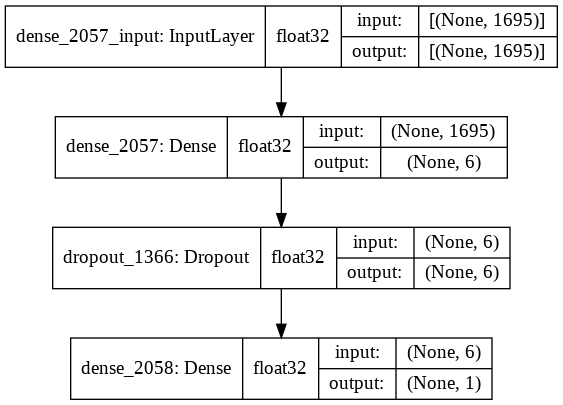

In [ ]:
#import Graphviz
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file=filedir + 'after-model.png')
plot_model(clf.model, show_shapes=True, show_dtype=True, show_layer_names=True)
